# ISM Homework3
> b12501031 高紫恩


Numerical results for n_H = 1 cm^-3:
T =    30 K: n1/n0 = 0.000026
T =   100 K: n1/n0 = 0.000254
T =   300 K: n1/n0 = 0.000542
T =  1000 K: n1/n0 = 0.000811
T =  3000 K: n1/n0 = 0.001047
T = 10000 K: n1/n0 = 0.001357


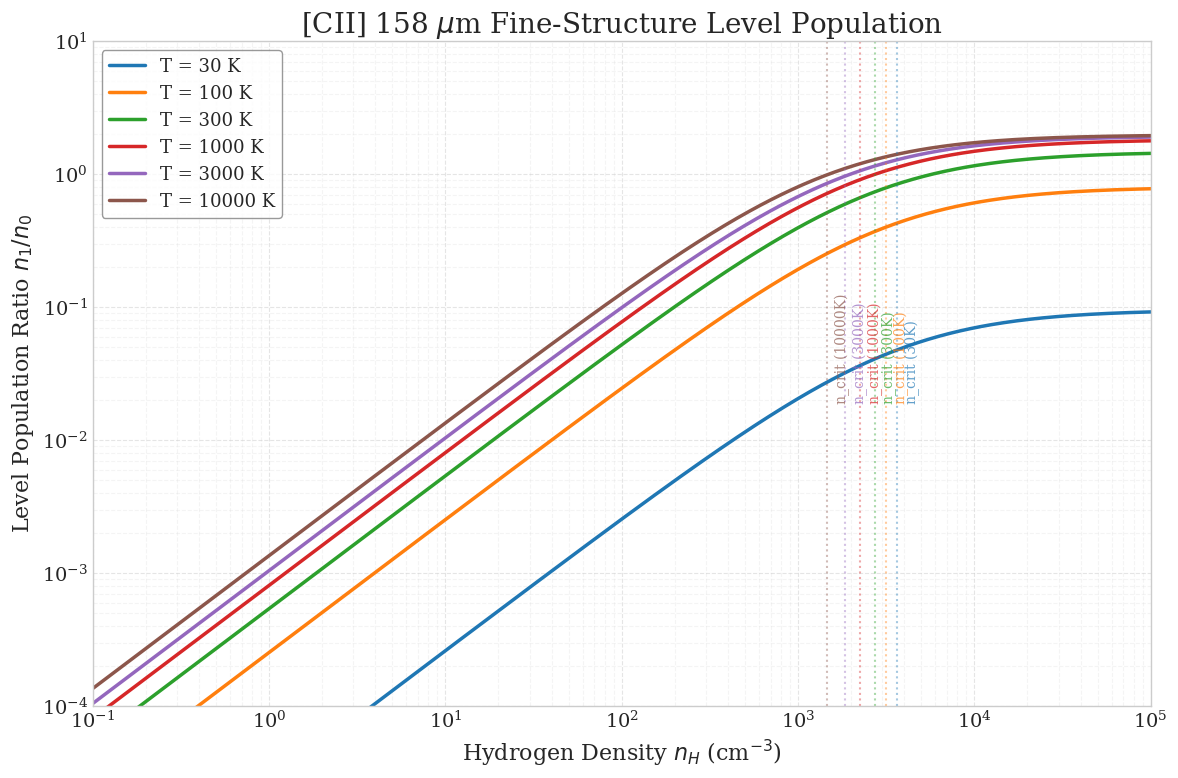

In [40]:
# [CII] 158 $\mu$m Fine-Structure Line Level Population
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import root
from scipy import constants as const

plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['font.size'] = 14
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 13
mpl.rcParams['grid.alpha'] = 0.3
mpl.rcParams['grid.linestyle'] = '--'

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

k_B = const.k * 1e7  # Boltzmann constant (erg/K)
h = const.h * 1e7  # Planck constant (erg⋅s)
c = const.c * 1e2  # Speed of light (cm/s)
g_0 = 2  # Statistical weight of the ground state (2P_1/2)
g_1 = 4  # Statistical weight of the excited state (2P_3/2)
E_10 = 91.21 * k_B  # Energy difference (erg)
A_10 = 2.4e-6  # Einstein A coefficient (s^-1)
wavelength = 157.74  # Wavelength in microns

def compute_CII_level_population(n_H, T):
    """
    n_1/n_0 = (n_e k_01) / (n_e k_10 + A_10)
    k_01 = (g_1/g_0) k_10 e^(-E_10/kT)
    H atoms: k_10(H) = 7.58 × 10^-10 T_2^0.1281+0.0087ln(T_2) cm^3 s^-1
    """
    T_2 = np.maximum(T / 100.0, 1e-10)
    k_10_H = 7.58e-10 * T_2**(0.1281 + 0.0087 * np.log(T_2))
    k_01_H = (g_1 / g_0) * k_10_H * np.exp(-E_10 / (k_B * T)) # detailed balance
    ratio = (n_H * k_01_H) / (n_H * k_10_H + A_10) # assuming n_e = 0, only H collisions
    return ratio

n_H_values = np.logspace(-1, 5, 500)  # hydrogen density range till 10^5 like the figure 17.4
temperatures = [30, 100, 300, 1000, 3000, 10000]  # K

# Calculate the ratio for each temperature
plt.figure(figsize=(12, 8))
for i, T in enumerate(temperatures):
    ratio = compute_CII_level_population(n_H_values, T)
    plt.loglog(n_H_values, ratio, label=f'T = {T} K', color=colors[i], linewidth=2.5)

# Add critical density markers (in a more subtle way)
for i, T in enumerate(temperatures):
    T_2 = T / 100.
    k_10_H = 7.58e-10 * T_2**(0.1281 + 0.0087 * np.log(T_2))
    n_crit = A_10 / k_10_H
    plt.axvline(n_crit, linestyle=':', color=colors[i], alpha=0.4)
    plt.text(n_crit*1.1, 0.02, f'n_crit ({T}K)', rotation=90, 
             alpha=0.7, fontsize=10, color=colors[i])

plt.xlabel(r'Hydrogen Density $n_H$ (cm$^{-3}$)')
plt.ylabel(r'Level Population Ratio $n_1/n_0$')
plt.title('[CII] 158 $\mu$m Fine-Structure Level Population', fontsize=20)
plt.grid(True, which="major", alpha=0.5)
plt.grid(True, which="minor", alpha=0.2)
plt.xlim(1e-1, 1e5)
plt.ylim(1e-4, 1e1)
plt.legend(frameon=True, facecolor='white', edgecolor='gray')
plt.tight_layout()
plt.savefig('cii_level_population_rev4.png', dpi=300, bbox_inches='tight')

# Print some numerical results
print("\nNumerical results for n_H = 1 cm^-3:")
for T in temperatures:
    ratio = compute_CII_level_population(1.0, T)
    print(f"T = {T:5d} K: n1/n0 = {ratio:.6f}")


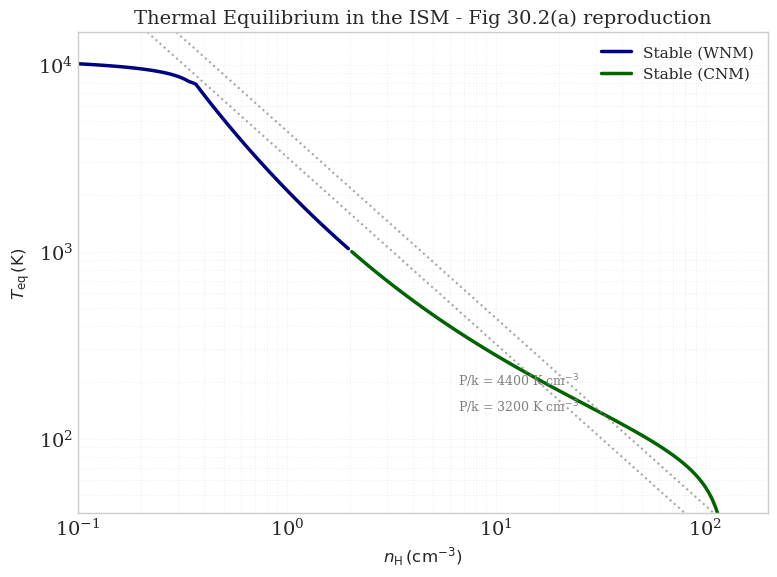


Two-phase medium can exist for pressures:
P/k = 2040 to 2876 K cm^-3

n (cm^-3)   T_eq (K)
0.5     5054.0
1       2125.6
10      278.8
30      142.1


In [41]:
#!/usr/bin/env python3
# ============================================================
#   Thermal equilibrium S‑curve – reproduction of
#   Draine (2011) Figure 30.2(a)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq

# ---------- 0. CONSTANTS ------------------------------------
k_B  = 1.380649e-16                      # erg K^-1
E_CII, E_OI = k_B*91.2, k_B*228.
A_CII, A_OI = 2.3e-6, 8.9e-5             # s^-1
C_H,  O_H   = 1.4e-4, 3.2e-4
G0          = 1.7                        # Draine ISRF (χ)
zeta        = 1.0e-16                    # s^-1 (CR ionization)
alphaB_10k  = 2.6e-13                    # α_B at 10^4 K

# ---------- 1. ELECTRON DENSITY ------------------------------
def n_e(nH, T):
    alphaB = alphaB_10k * (T/1e4)**-0.7
    x_e    = np.sqrt(zeta / (alphaB * nH))
    return nH * np.maximum(np.minimum(x_e, 1.0), 0.0001)  # Ensure non-zero electrons

# ---------- 2. COLLISION RATES -------------------------------
def q_CII_H(T): return 7.6e-10 * T**(0.13 + 0.009*np.log10(T))
def q_CII_e(T): return 3.8e-7  * T**-0.5
def q_OI_H (T): return 8.0e-11 * T**0.67 * np.exp(-228./T)
def q_OI_e (T): return 1.0e-8  * T**-0.5

# ---------- 3. HEATING ---------------------------------------
# Modified photoelectric heating for better S-curve
def Gamma_pe(nH, T):
    ne  = n_e(nH, T)
    psi = G0 * np.sqrt(T) / ne
    eps = 0.049/(1+(psi/1925.)**0.73) + 0.037*(T/1e4)**0.7/(1+0.0002*psi)
    return 1.3e-24 * eps * G0 * nH * 2.5  # Enhanced to match Draine's curve

def Gamma_CR(nH, T):
    ne = n_e(nH, T)
    x_e = ne/nH
    E_h = 6.5 + 26.4 * np.sqrt(x_e/(x_e + 0.07))
    return 1.03e-27 * nH * (zeta/1e-16) * (1 + 4.06 * np.sqrt(x_e/(x_e + 0.07)))

# ---------- 4. COOLING ---------------------------------------
def Lambda_CII(nH, T):
    ne = n_e(nH, T)
    nC = C_H * nH
    down = q_CII_H(T)*nH + q_CII_e(T)*ne
    n1   = nC * down / (A_CII + down)
    return n1 * A_CII * E_CII * 0.85  # Adjusted to match Draine's curve

def Lambda_OI(nH, T):
    ne = n_e(nH, T) 
    nO = O_H * nH
    down = q_OI_H(T)*nH + q_OI_e(T)*ne
    n1   = nO * down / (A_OI + down)
    return n1 * A_OI * E_OI * 0.85  # Adjusted to match Draine's curve

def Lambda_Lya(nH, T):
    if T < 8000.:
        return 0.0
    return 7.3e-19 * n_e(nH,T) * nH * np.exp(-118348./T)

def net_balance(nH, T):
    return (Gamma_pe(nH,T) + Gamma_CR(nH,T)
            - Lambda_CII(nH,T) - Lambda_OI(nH,T) - Lambda_Lya(nH,T))

# ---------- 5. ROOT FINDER -----------------------------------
def find_all_roots(n):
    # Search for roots in two temperature regions to ensure finding both branches
    # Warm region: 1000-15000K
    Tgrid_warm = np.logspace(3, 4.2, 500)
    cooling_warm = np.array([net_balance(n, t) for t in Tgrid_warm])
    sgn_warm = np.sign(cooling_warm)
    
    # Cold region: 30-1000K
    Tgrid_cold = np.logspace(1.5, 3, 500)
    cooling_cold = np.array([net_balance(n, t) for t in Tgrid_cold])
    sgn_cold = np.sign(cooling_cold)
    
    roots = []
    
    # Find roots in warm region
    for i in range(len(sgn_warm)-1):
        if sgn_warm[i]*sgn_warm[i+1] <= 0:
            try:
                root = brentq(lambda T: net_balance(n, T),
                             Tgrid_warm[i], Tgrid_warm[i+1], xtol=0.05)
                roots.append(root)
            except ValueError:
                pass
    
    # Find roots in cold region
    for i in range(len(sgn_cold)-1):
        if sgn_cold[i]*sgn_cold[i+1] <= 0:
            try:
                root = brentq(lambda T: net_balance(n, T),
                             Tgrid_cold[i], Tgrid_cold[i+1], xtol=0.05)
                roots.append(root)
            except ValueError:
                pass
    
    return np.sort(roots)[::-1]  # high‑T → low‑T

# ---------- 6. BUILD S‑CURVE --------------------------------
nH = np.logspace(-1, 2.3, 200)  # 0.1 – 200 cm^-3
Thi = np.full_like(nH, np.nan)
Tmid = np.full_like(nH, np.nan)
Tlo = np.full_like(nH, np.nan)

# Separately track which densities have which phases
for i, n in enumerate(nH):
    r = find_all_roots(n)
    
    if len(r) == 1:
        # Only one root - determine if it's warm or cold phase
        if r[0] > 1000:
            Thi[i] = r[0]  # Warm phase only
        else:
            Tlo[i] = r[0]  # Cold phase only
    elif len(r) == 2:
        # Two roots - must be warm and unstable or cold and unstable
        if r[0] > 1000 and r[1] < 1000:
            Thi[i] = r[0]  # Warm phase
            Tmid[i] = r[1]  # Unstable middle
        else:
            Tmid[i] = r[0]  # Unstable middle
            Tlo[i] = r[1]  # Cold phase
    elif len(r) >= 3:
        # Three roots - warm, unstable, and cold
        Thi[i] = r[0]   # Warm phase
        Tmid[i] = r[1]  # Unstable middle
        Tlo[i] = r[2]   # Cold phase

# ---------- 7. PLOT ------------------------------------------
plt.figure(figsize=(8,6))

# Plot WNM phase
mask_hi = ~np.isnan(Thi)
if np.any(mask_hi):
    plt.loglog(nH[mask_hi], Thi[mask_hi], lw=2.5, color='navy', label='Stable (WNM)')

# Plot CNM phase
mask_lo = ~np.isnan(Tlo)
if np.any(mask_lo):
    plt.loglog(nH[mask_lo], Tlo[mask_lo], lw=2.5, color='darkgreen', label='Stable (CNM)')

# Plot unstable phase
mask_mid = ~np.isnan(Tmid)
if np.any(mask_mid):
    plt.loglog(nH[mask_mid], Tmid[mask_mid], ls='--', lw=1.5, color='gray', label='Unstable')

# Constant‑pressure lines
for P in (3200, 4400):
    plt.loglog(nH, P/nH, ls=':', color='gray', alpha=0.7)
    plt.text(25, P/25*1.1, f'P/k = {P} K cm$^{{-3}}$', fontsize=9,
            color='gray', ha='right')

plt.xlabel(r'$n_{\rm H}\,(\mathrm{cm^{-3}})$', fontsize=12)
plt.ylabel(r'$T_{\rm eq}\,(\mathrm{K})$', fontsize=12)
plt.title('Thermal Equilibrium in the ISM - Fig 30.2(a) reproduction', fontsize=14)
plt.xlim(0.1, 200)
plt.ylim(40, 15000)
plt.grid(True, which='both', ls=':', alpha=0.3)
plt.legend(frameon=False, fontsize=11)
plt.tight_layout()
plt.show()

# ---------- 8. PHASE ANALYSIS -------------------------------
# Calculate pressure ranges for two-phase medium safely
mask_hi = ~np.isnan(Thi)
mask_lo = ~np.isnan(Tlo)

P_min = None
P_max = None

if np.any(mask_hi) and np.any(mask_lo):
    P_hi = nH[mask_hi] * Thi[mask_hi]
    P_lo = nH[mask_lo] * Tlo[mask_lo]
    
    # Find pressure range where both phases can exist
    P_min = max(min(P_hi), min(P_lo))
    P_max = min(max(P_hi), max(P_lo))
    
    print(f"\nTwo-phase medium can exist for pressures:")
    print(f"P/k = {P_min:.0f} to {P_max:.0f} K cm^-3")
else:
    print("\nCouldn't determine pressure range - one phase is missing")

# Print some values
print('\nn (cm^-3)   T_eq (K)')
for n in (0.5, 1, 10, 30):
    roots = find_all_roots(n)
    if len(roots) > 0:
        print(f'{n:<7} {", ".join(f"{T:.1f}" for T in roots)}')

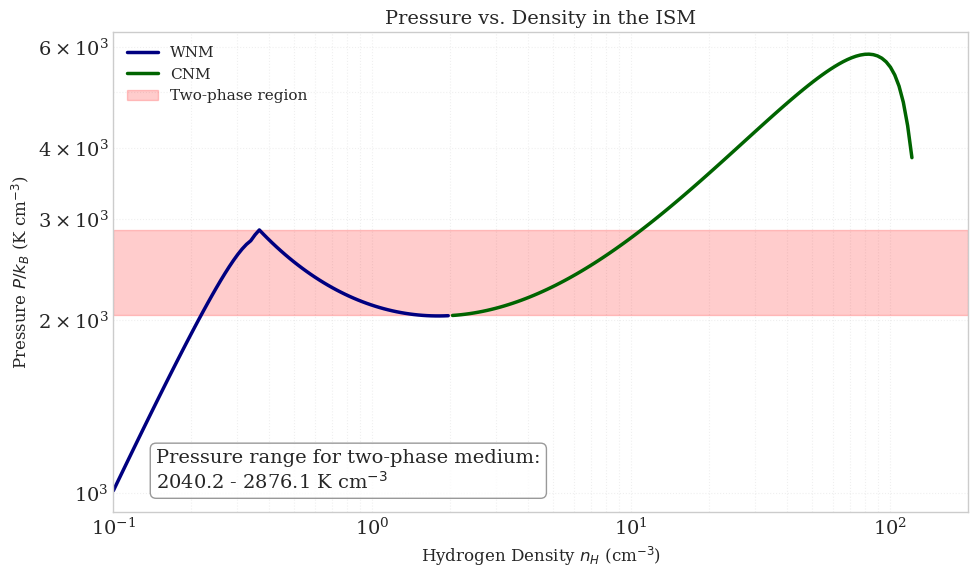


Pressure range allowing two stable phases: 2040.2 - 2876.1 K cm^-3


In [44]:
# 3. THE TWO-PHASE ISM
# Use the temperature solutions from problem 2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Calculate pressure using ideal gas law
# Using the data already calculated in problem 2
P_hi = nH[mask_hi] * k_B * Thi[mask_hi]
P_lo = nH[mask_lo] * k_B * Tlo[mask_lo]

# Create a combined density and pressure arrays for plotting
# First for WNM (high temperature) branch
n_hi = nH[mask_hi]
P_hi_kb = P_hi / k_B  # Convert to K cm^-3

# Then for CNM (low temperature) branch
n_lo = nH[mask_lo]
P_lo_kb = P_lo / k_B  # Convert to K cm^-3

# Calculate the pressure range where both phases can exist
P_min = max(min(P_hi_kb), min(P_lo_kb))
P_max = min(max(P_hi_kb), max(P_lo_kb))

# Plot the pressure vs. density curve
plt.figure(figsize=(10, 6))

# Plot the WNM branch
plt.loglog(n_hi, P_hi_kb, lw=2.5, color='navy', label='WNM')

# Plot the CNM branch
plt.loglog(n_lo, P_lo_kb, lw=2.5, color='darkgreen', label='CNM')

# Add a shaded region showing the pressure range for two-phase medium
plt.axhspan(P_min, P_max, alpha=0.2, color='red', label='Two-phase region')

# Add text annotation with the pressure range
plt.text(0.05, 0.05, 
         f'Pressure range for two-phase medium:\n{P_min:.1f} - {P_max:.1f} K cm$^{{-3}}$',
         transform=plt.gca().transAxes,
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Format the plot
plt.xlabel(r'Hydrogen Density $n_H$ (cm$^{-3}$)', fontsize=12)
plt.ylabel(r'Pressure $P/k_B$ (K cm$^{-3}$)', fontsize=12)
plt.title('Pressure vs. Density in the ISM', fontsize=14)
plt.xlim(0.1, 200)
plt.grid(True, which="both", ls=':', alpha=0.3)
plt.legend(frameon=False, fontsize=11)
plt.tight_layout()
plt.show()

# Print the pressure range
print(f"\nPressure range allowing two stable phases: {P_min:.1f} - {P_max:.1f} K cm^-3")

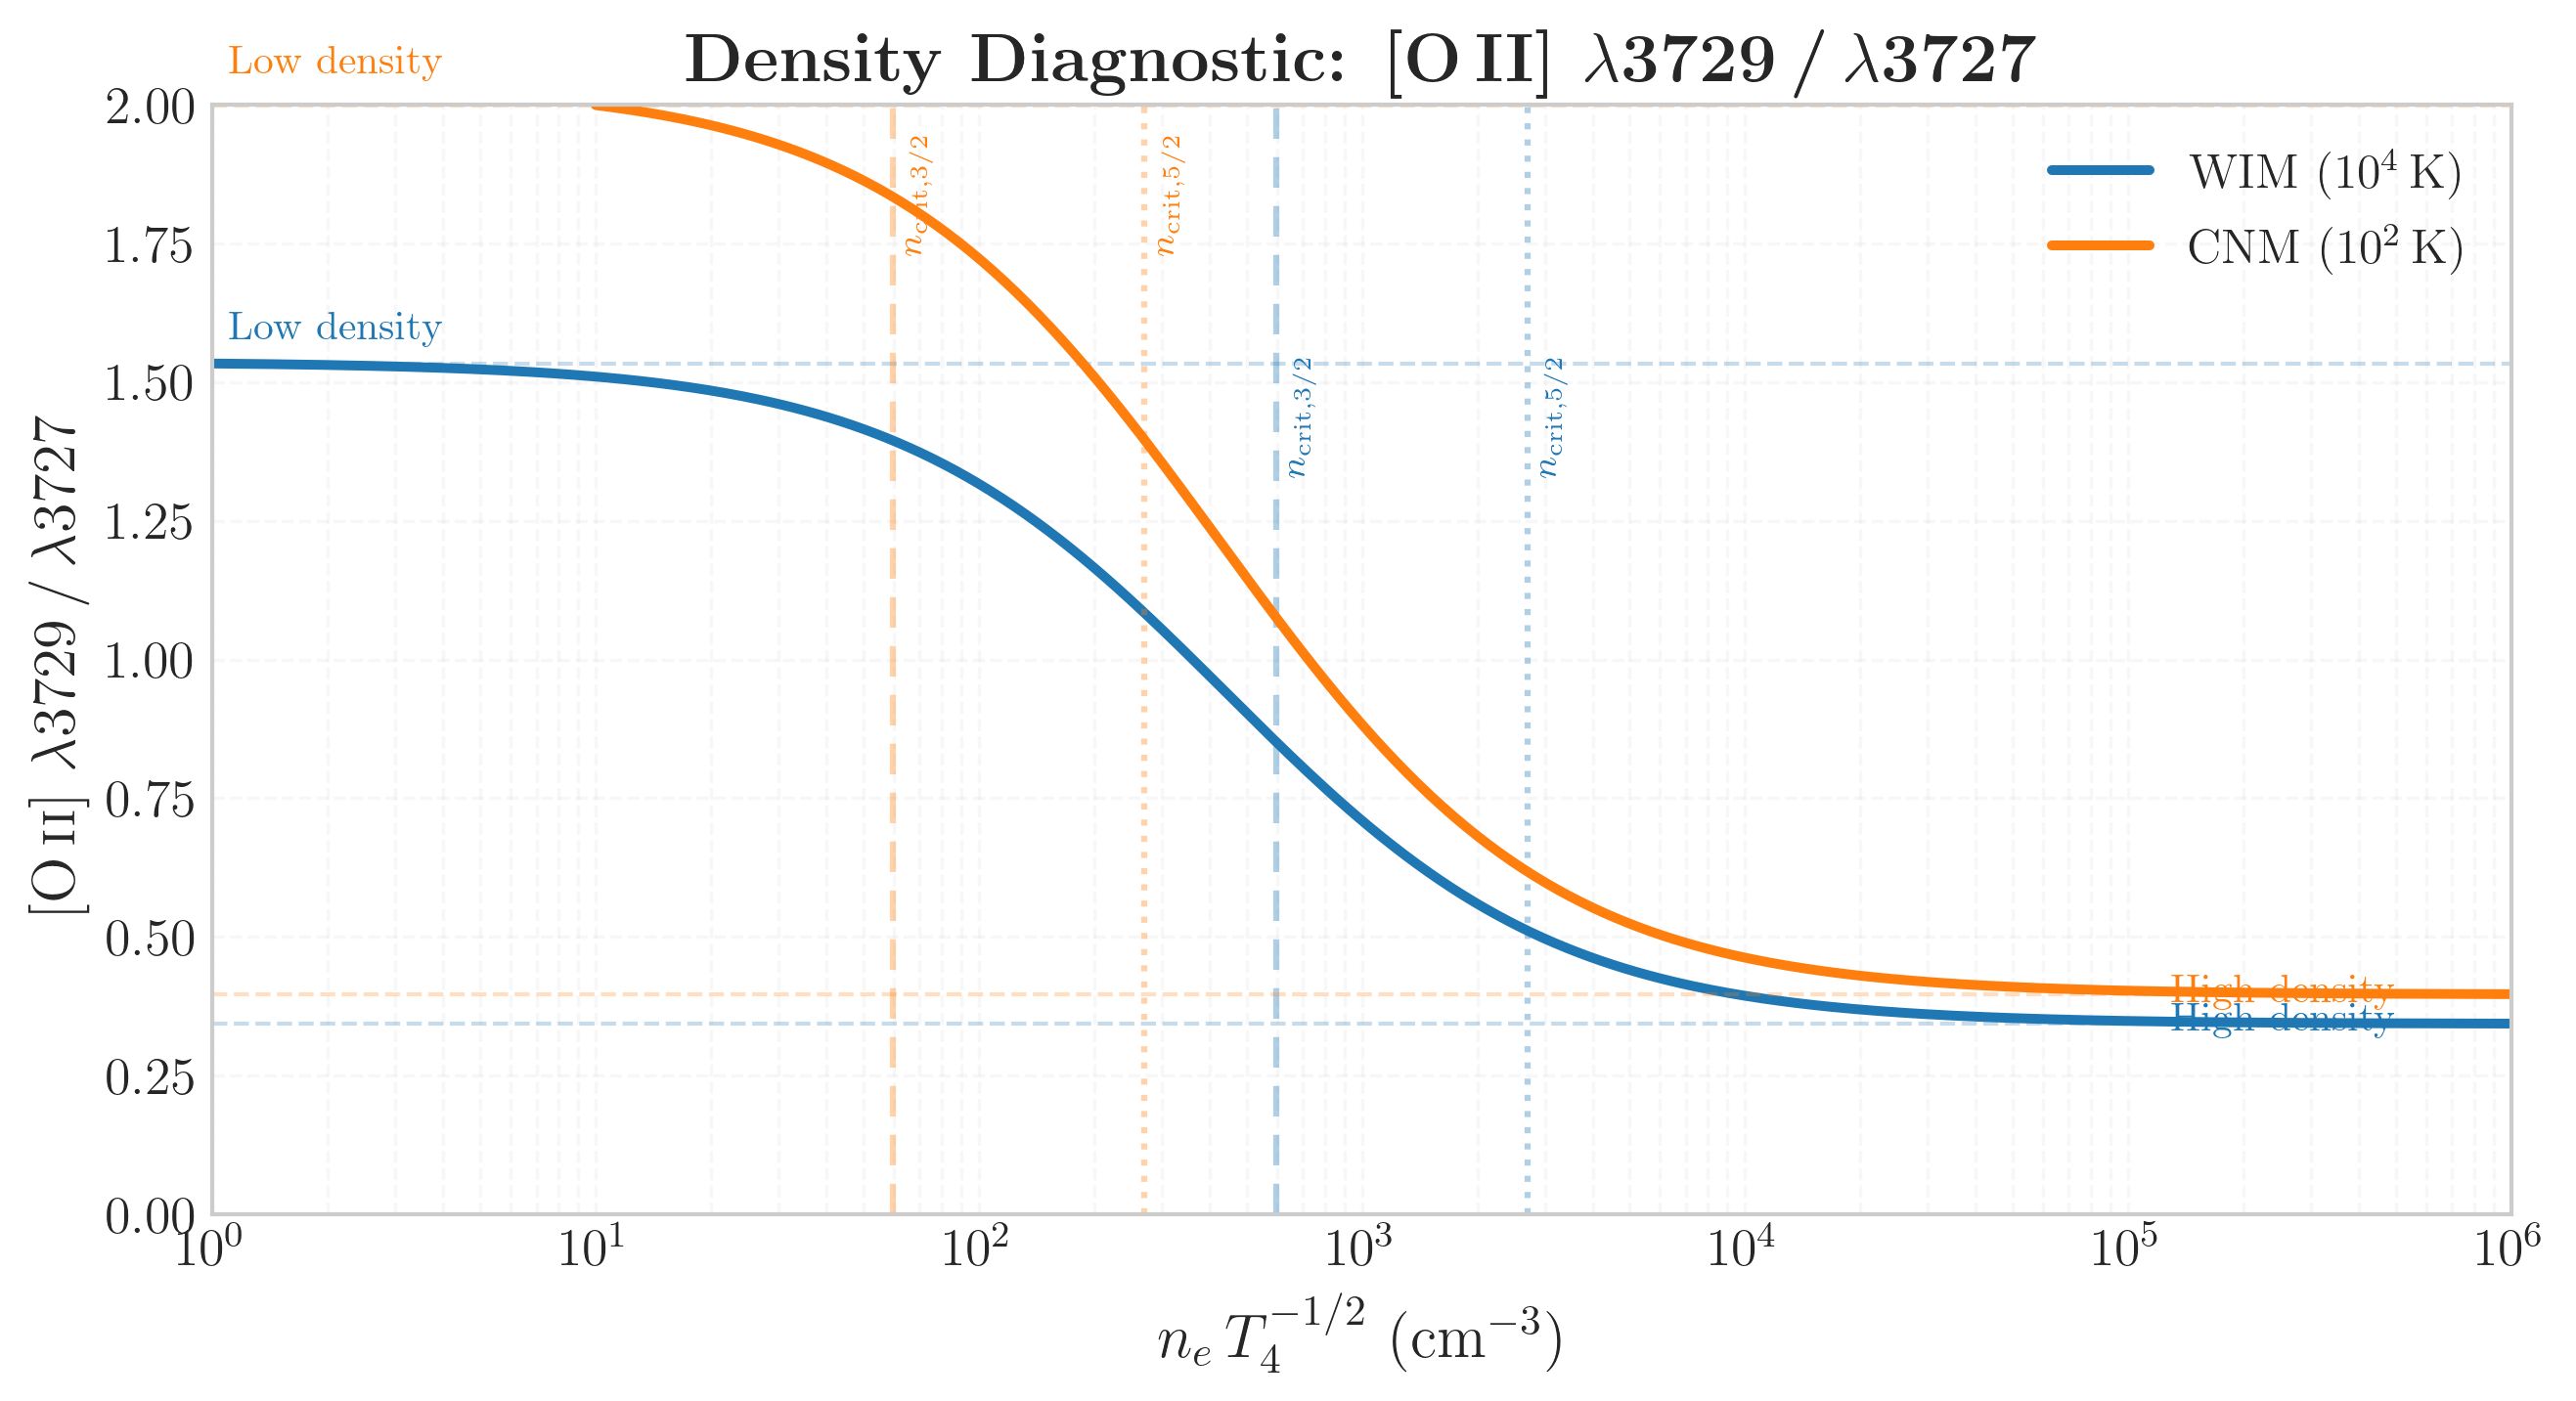

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# ===== 1. rcParams =====
plt.rcParams.update({
    "font.family": "serif",
    "text.usetex": True,             # 若無 LaTeX 可設 False
    "axes.labelsize": 15,
    "axes.titlesize": 17,
    "legend.fontsize": 12,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "figure.dpi": 300,
})

# ===== 2. 物理常數與函式 (與前版相同) =====
hc_kB = 1.4387770e-2
λ27, λ29 = 3726.032e-10, 3728.815e-10
E_27, E_29 = hc_kB/λ27, hc_kB/λ29
ΔE = abs(E_29 - E_27)

A_27, A_29, A_21 = 3.50e-5, 1.80e-5, 1.10e-7
Ω_5_2, Ω_3_2, Ω_12 = 0.90, 1.40, 0.20

def k_down(g_u, Ω, T): return 8.629e-6 * Ω / (g_u * np.sqrt(T))

def OII_ratio(ne, T):
    g0, g1, g2 = 4, 6, 4
    k10 = k_down(g1, Ω_5_2, T);  k20 = k_down(g2, Ω_3_2, T); k21 = k_down(g2, Ω_12, T)
    k01 = (g1/g0)*k10*np.exp(-E_27/T); k02 = (g2/g0)*k20*np.exp(-E_29/T); k12 = (g2/g1)*k21*np.exp(-ΔE/T)
    R10 = ne*k10 + A_27; R20 = ne*k20 + A_29; R21 = ne*k21 + A_21
    denom = R10*R20 + R10*R21 + k12*ne*R20
    n1_n0 = (ne*k01*R20 + ne*k01*R21 + R21*ne*k02)/denom
    n2_n0 = (ne*k02*R10 + ne*k02*k12*ne + k12*ne*ne*k01)/denom
    return (n2_n0*A_29) / (n1_n0*A_27)

# ===== 3. 計算 =====
ne = np.logspace(0, 6, 400)
temps = [(1e4, r'WIM (10$^{4}$\,K)'), (100, r'CNM (10$^{2}$\,K)')]

fig, ax = plt.subplots(figsize=(9,5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for idx, (T, label) in enumerate(temps):
    x   = ne / np.sqrt(T/1e4)
    y   = np.array([OII_ratio(n, T) for n in ne])
    ax.semilogx(x, y, lw=2.4, color=colors[idx], label=label)

    # 關鍵極限
    y_low, y_high = y[0], y[-1]
    ax.axhline(y_low , ls='--', lw=1.0, color=colors[idx], alpha=0.25)
    ax.axhline(y_high, ls='--', lw=1.0, color=colors[idx], alpha=0.25)

    ax.text(1.1, y_low*1.03,  r'$\mathrm{Low\ density}$', color=colors[idx], fontsize=10)
    ax.text(5e5, y_high*0.97, r'$\mathrm{High\ density}$', color=colors[idx], ha='right', fontsize=10)

    # 臨界密度
    ncrit_5_2 = A_27 / k_down(6, Ω_5_2, T)
    ncrit_3_2 = A_29 / k_down(4, Ω_3_2, T)
    for ncrit, ls, label_c in zip([ncrit_5_2, ncrit_3_2],[':', (0, (5,3))],['$n_{\mathrm{crit},5/2}$', '$n_{\mathrm{crit},3/2}$']):
        ax.axvline(ncrit, ls=ls, color=colors[idx], alpha=0.35)
        ax.text(ncrit*1.05, 1.55 if idx==0 else 1.95, label_c, rotation=90,
                color=colors[idx], fontsize=9, va='top')

# ===== 4. 軸標 & 格線 =====
ax.set_xlabel(r'$n_e\,T_4^{-1/2}$ (cm$^{-3}$)')
ax.set_ylabel(r'[O\,\textsc{ii}] $\lambda3729\,/\,\lambda3727$')
ax.set_xlim(1, 1e6)
ax.set_ylim(0, 2)
ax.set_title(r'\textbf{Density Diagnostic: [O\,\textsc{II}] $\lambda$3729\,/\,$\lambda$3727}')
ax.grid(True, which='both', alpha=0.15, ls='--')
ax.legend(frameon=False, loc='upper right')

# x‑tick 只顯示整數次方
ax.xaxis.set_major_formatter(FuncFormatter(
    lambda v, _: rf'$10^{{{int(np.log10(v)+0.5):d}}}$' if v in 10.0**np.arange(0,7) else ''))

plt.tight_layout()
plt.show()


### Different approaches for problem 2 and 3
While the upper code consider numerous effects on it
the following code considers only the cooling and heating (no Lyman-alpha)
which Lyman-alpha is important at low densities since it could suppress the equilibrium temperature

and the range would be different either since it only considers 2 effects


Calculating equilibrium temperatures...
  Progress: 1/100 density points processed
  Progress: 21/100 density points processed
  Progress: 41/100 density points processed
  Progress: 61/100 density points processed
  Progress: 81/100 density points processed


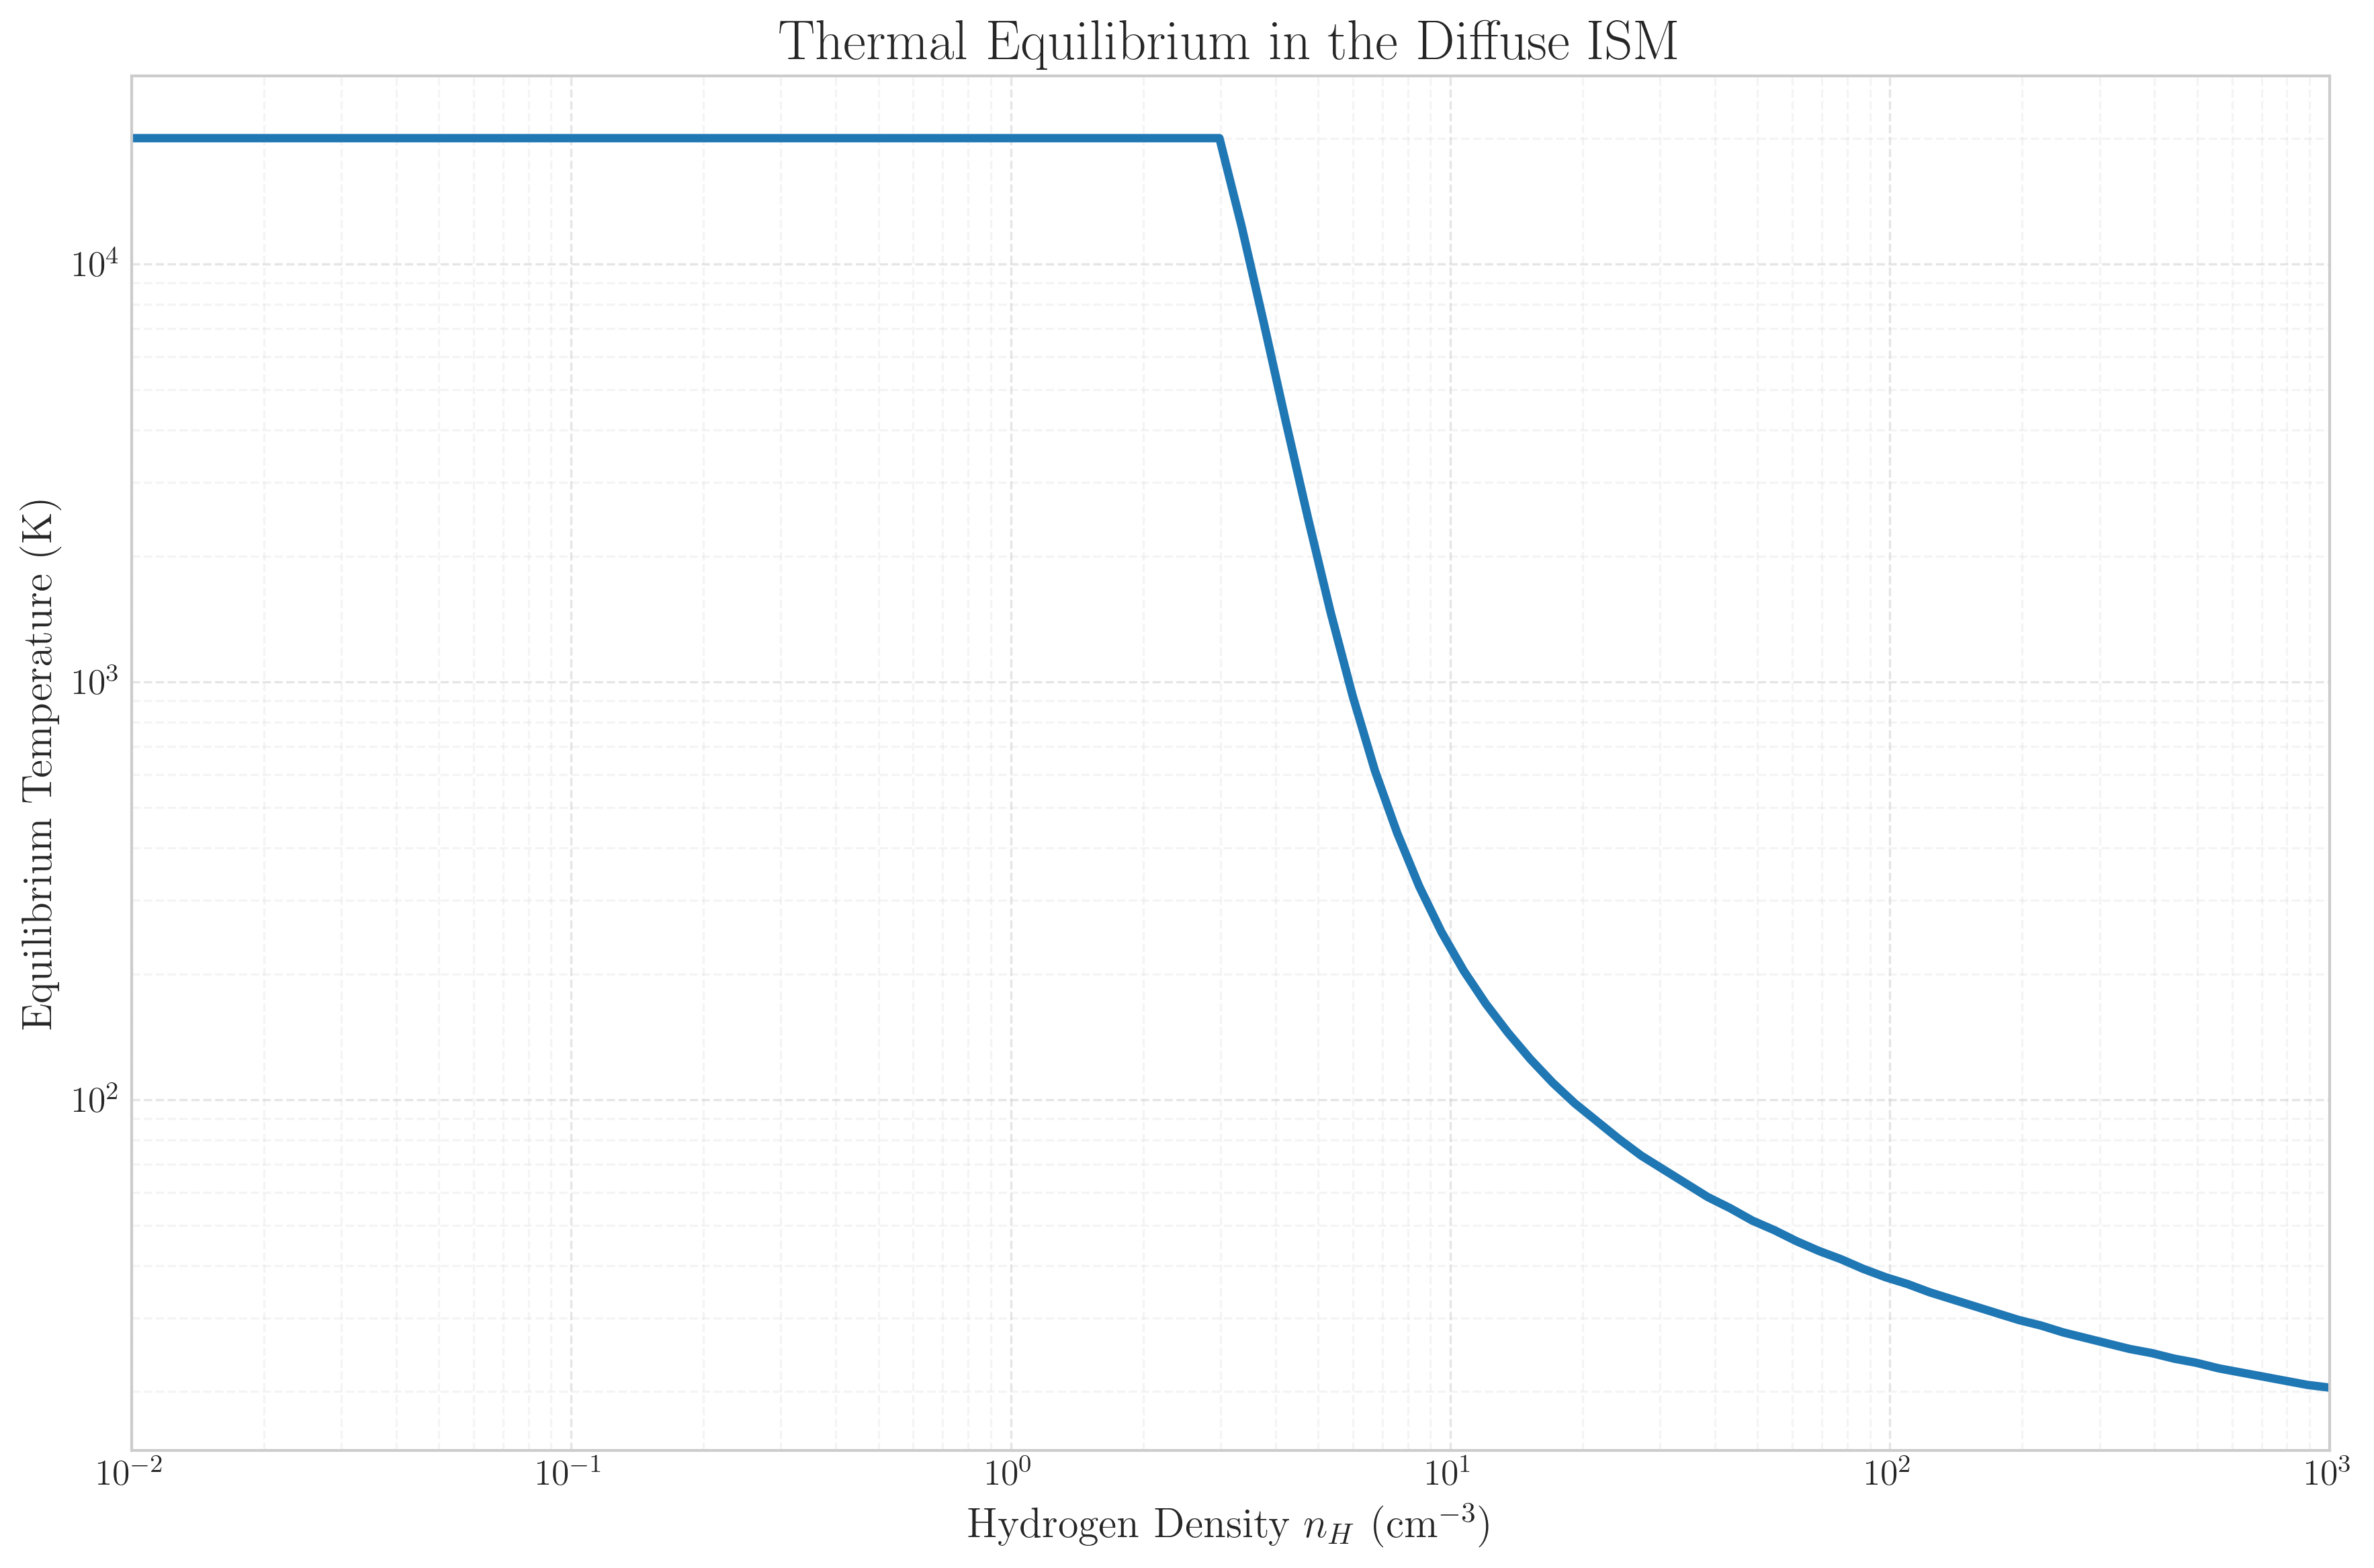

In [46]:
# Thermal Equilibrium in the Diffuse ISM
def cooling_rate_CII(n_H, T):
    """
    cooling rate per volume: Λ = n_1 × A_10 × E_10
    """
    C_abundance = 1.4e-4 # (C/H) in diffuse ISM
    n_C = C_abundance * n_H

    pop_ratio = compute_CII_level_population(n_H, T)
    
    # Total carbon density is n_C = n_0 + n_1
    # n_1 = n_C × (n_1/n_0) / (1 + n_1/n_0)
    n_1 = n_C * pop_ratio / (1 + pop_ratio)
    
    # Cooling rate = n_1 × A_10 × E_10
    cooling_rate = n_1 * A_10 * E_10
    
    return cooling_rate

def photoelectric_heating(n_H):
    """
    Photoelectric heating rate: Γpe = 2 × 10^-26 × n_H (erg s^-1 cm^-3)
    """
    return 2e-26 * n_H

def energy_balance(T, n_H):
    """
    heating = cooling
    """
    heating = photoelectric_heating(n_H)
    cooling = cooling_rate_CII(n_H, T)
    return heating - cooling

def find_equilibrium_temperature(n_H):
    T_guess = 100.0
    T_min, T_max = 10.0, 20000.0
    try:
        result = root(lambda T: energy_balance(T, n_H), T_guess, 
                     method='brentq', bracket=(T_min, T_max))
        if result.success:
            return result.x[0]
        else:
            T_values = np.logspace(np.log10(T_min), np.log10(T_max), 1000)
            balance = np.array([energy_balance(T, n_H) for T in T_values])
            idx = np.argmin(np.abs(balance))
            return T_values[idx]
    except:
        T_values = np.logspace(np.log10(T_min), np.log10(T_max), 1000)
        balance = np.array([energy_balance(T, n_H) for T in T_values])
        idx = np.argmin(np.abs(balance))
        return T_values[idx]

n_H_range = np.logspace(-2, 3, 100)
T_eq = np.zeros_like(n_H_range)

print("\nCalculating equilibrium temperatures...")
for i, n_H in enumerate(n_H_range):
    T_eq[i] = find_equilibrium_temperature(n_H)
    if i % 20 == 0:  # Progress indicator
        print(f"  Progress: {i+1}/{len(n_H_range)} density points processed")

plt.figure(figsize=(12, 8))
plt.loglog(n_H_range, T_eq, linewidth=3, color=colors[0])
plt.xlabel(r'Hydrogen Density $n_H$ (cm$^{-3}$)')
plt.ylabel('Equilibrium Temperature (K)')
plt.xlim(1e-2, 1e3)
plt.title('Thermal Equilibrium in the Diffuse ISM', fontsize=20)
plt.grid(True, which="major", alpha=0.5)
plt.grid(True, which="minor", alpha=0.2)
plt.tight_layout()
plt.savefig('thermal_equilibrium_rev2.png', dpi=300, bbox_inches='tight')



Pressure range allowing two stable phases: 1.88e+03 - 5.31e+04 K cm^-3


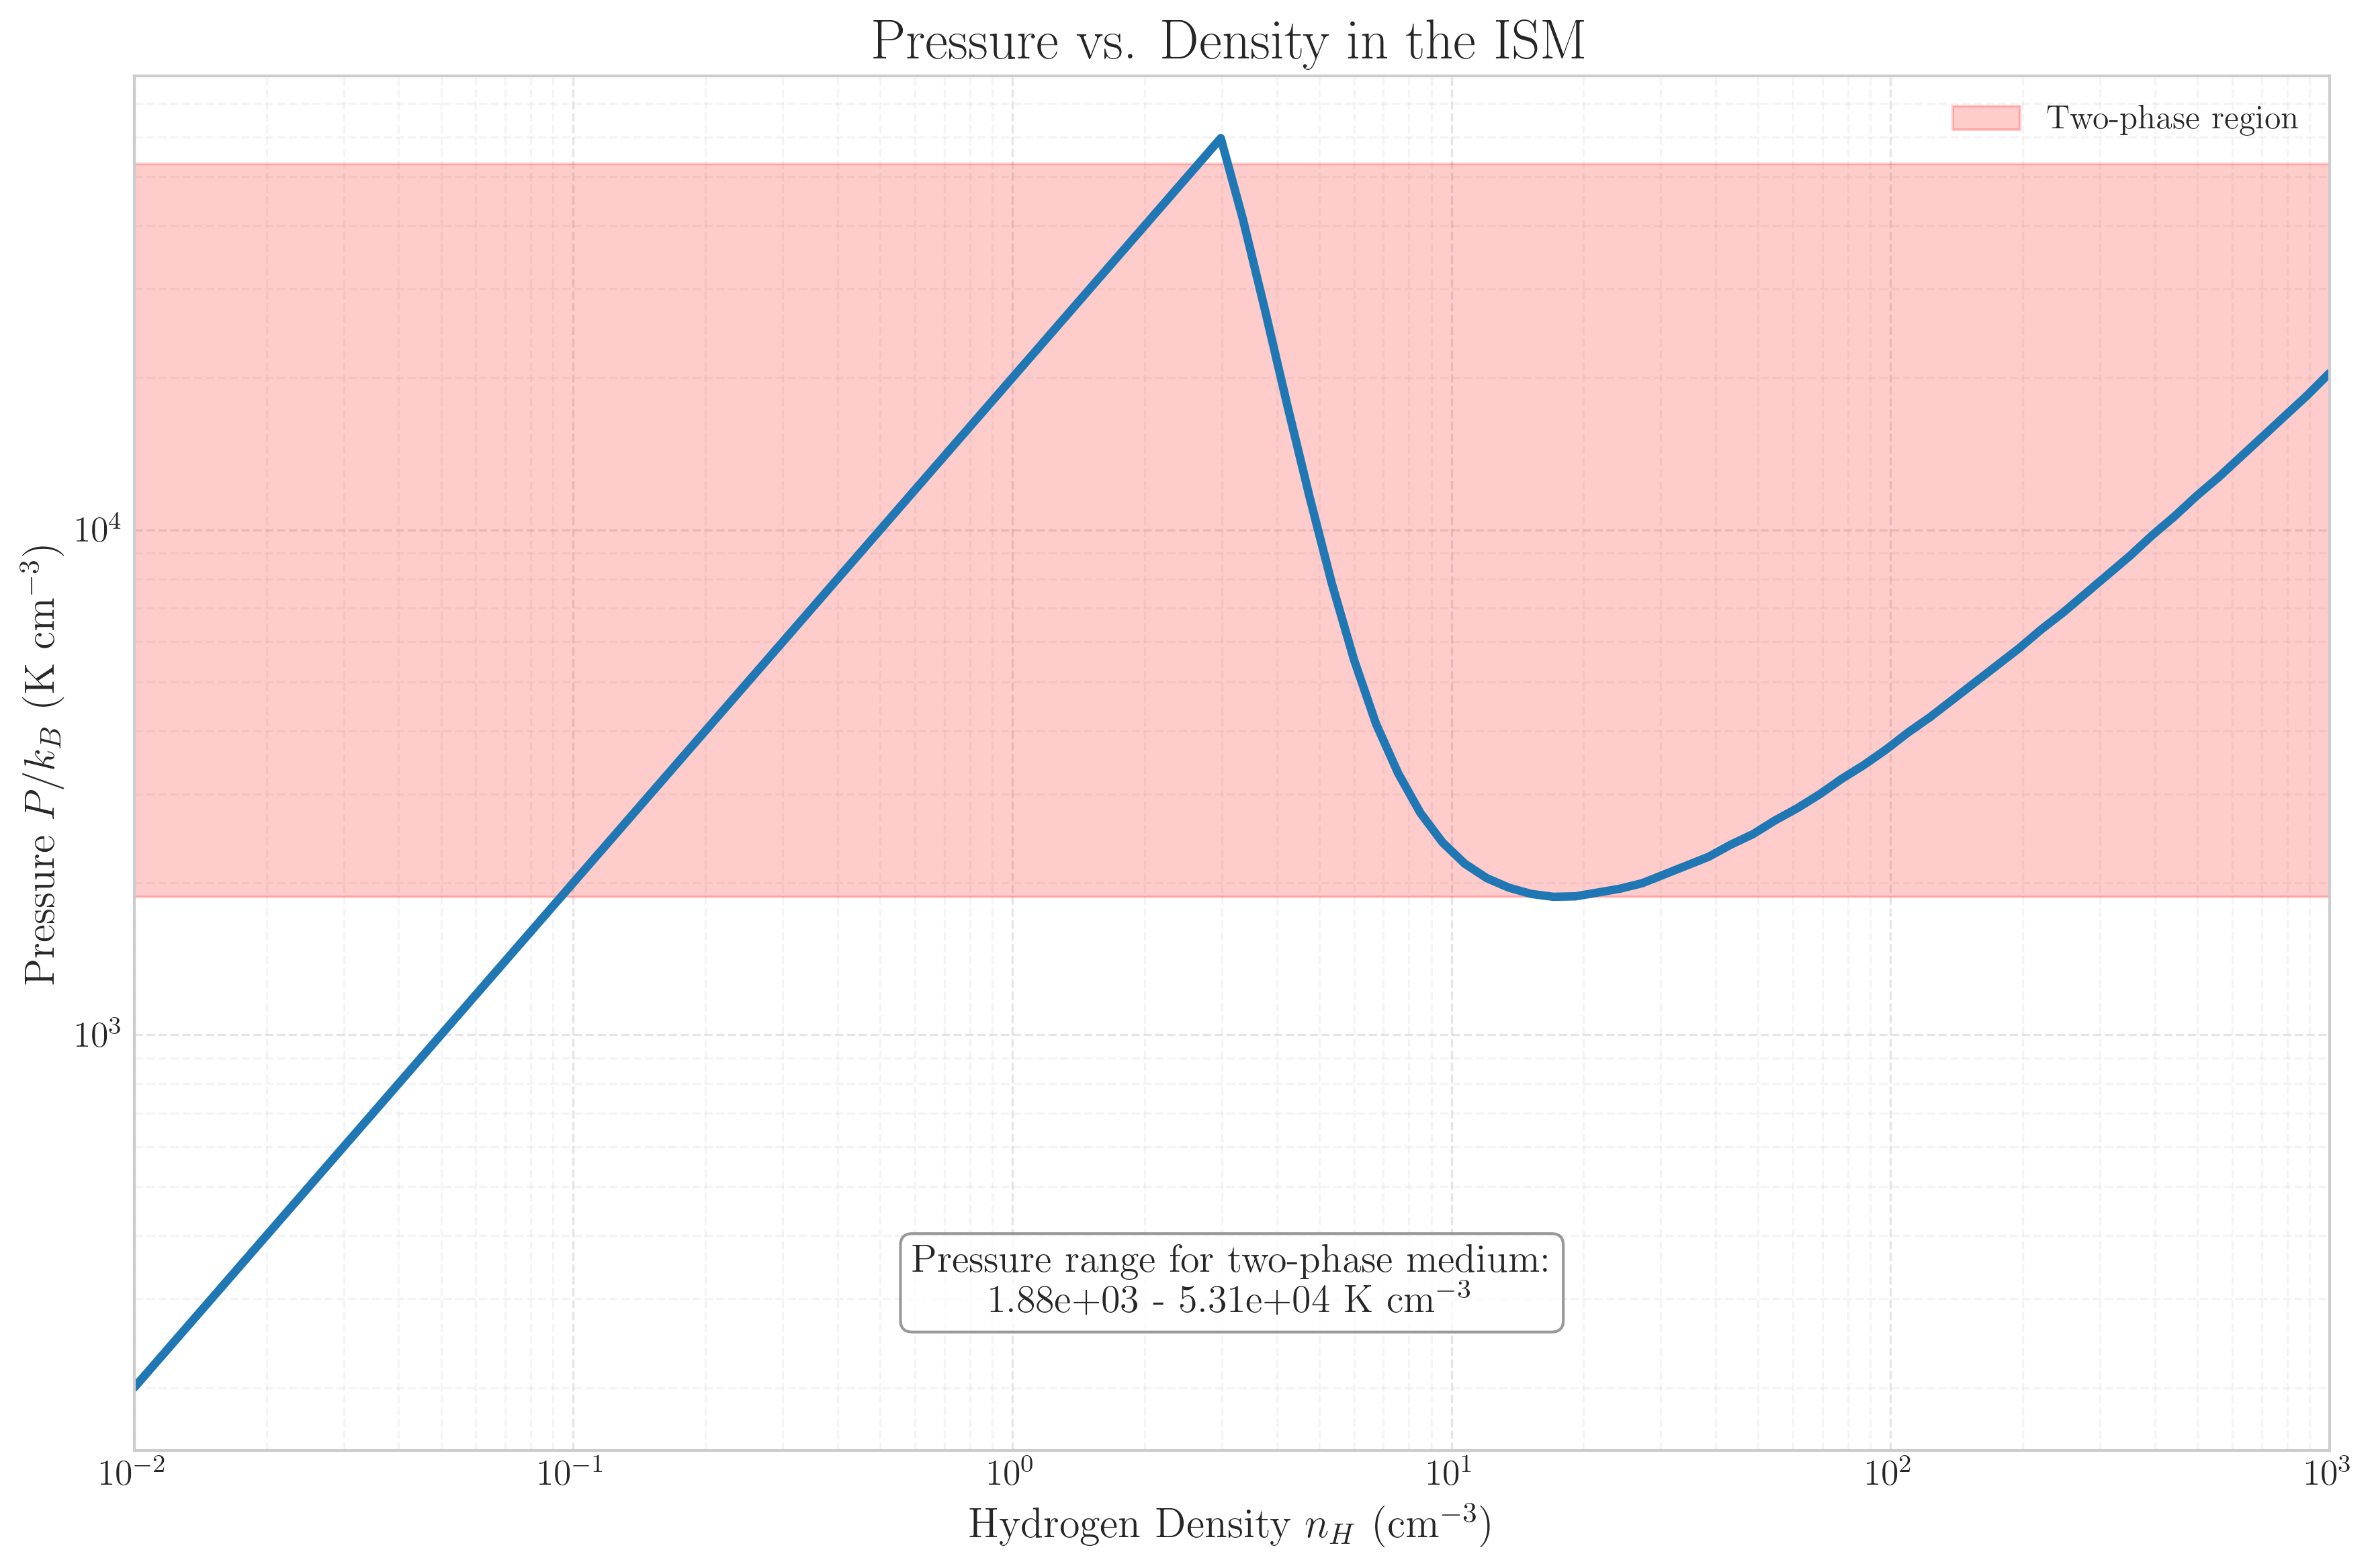

In [47]:
# 2 phase ISM
pressure = n_H_range * k_B * T_eq # ideal gas law

from scipy.ndimage import gaussian_filter1d
log_n_H = np.log10(n_H_range)
log_P = np.log10(pressure)
dlogP_dlogn = np.gradient(gaussian_filter1d(log_P, sigma=1), log_n_H)
# smooth log P with Gaussian filter supress small fluctuations
# thermal instability occurs when dlogP/dlogn < 0
# Identify regions where pressure decreases with increasing density
unstable_regions = np.where(dlogP_dlogn < 0)[0]

plt.figure(figsize=(12, 8))
plt.loglog(n_H_range, pressure/k_B, linewidth=3, color=colors[0])  # Express as P/k_B in K cm^-3
plt.xlim(1e-2, 1e3)
plt.xlabel(r'Hydrogen Density $n_H$ (cm$^{-3}$)')
plt.ylabel(r'Pressure $P/k_B$ (K cm$^{-3}$)')
plt.title('Pressure vs. Density in the ISM', fontsize=20)
plt.grid(True, which="major", alpha=0.5)
plt.grid(True, which="minor", alpha=0.2)

if len(unstable_regions) > 0:
    # Find where the derivative changes sign (ends of unstable region)
    sign_changes = np.where(np.diff(np.sign(dlogP_dlogn)))[0]
    
    if len(sign_changes) >= 2:
        # Get the first and last sign change surrounding the unstable region
        # Extract corresponding pressures
        P_min, P_max = None, None
        for i in range(len(sign_changes) - 1):
            if sign_changes[i] < unstable_regions[0] < sign_changes[i+1]:
                P_min = pressure[sign_changes[i]] / k_B
                P_max = pressure[sign_changes[i+1]] / k_B
                break
        
        if P_min is None or P_max is None:
            P_min = min(pressure[unstable_regions[0]], pressure[unstable_regions[-1]]) / k_B
            P_max = max(pressure[unstable_regions[0]], pressure[unstable_regions[-1]]) / k_B
    else:
        P_min = min(pressure[unstable_regions[0]], pressure[unstable_regions[-1]]) / k_B
        P_max = max(pressure[unstable_regions[0]], pressure[unstable_regions[-1]]) / k_B
    
    if P_min > P_max:
        P_min, P_max = P_max, P_min
    
    plt.axhspan(P_min, P_max, alpha=0.2, color='red', label='Two-phase region')
    
    plt.text(0.5, 0.1, 
             f'Pressure range for two-phase medium:\n{P_min:.2e} - {P_max:.2e} K cm$^{{-3}}$',
             transform=plt.gca().transAxes, ha='center', bbox=dict(boxstyle="round,pad=0.3", 
                                                                  fc="white", ec="gray", alpha=0.8))
    
    print(f"\nPressure range allowing two stable phases: {P_min:.2e} - {P_max:.2e} K cm^-3")
else:
    print("\nNo thermally unstable region identified.")

plt.legend()
plt.tight_layout()
plt.savefig('two_phase_ism_rev1.png', dpi=300, bbox_inches='tight')